Source: https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd/tree/master/tensorflow-rnn-tutorial

# An RNN model to generate sequences
RNN models can generate long sequences based on past data. This can be used to predict stock markets, temperatures, traffic or sales data based on past patterns. They can also be adapted to [generate text](https://docs.google.com/presentation/d/18MiZndRCOxB7g-TcCl2EZOElS5udVaCuxnGznLnmOlE/pub?slide=id.g139650d17f_0_1185). The quality of the prediction will depend on training data, network architecture, hyperparameters, the distance in time at which you are predicting and so on. But most importantly, it will depend on wether your training data contains examples of the behaviour you are trying to predict.

<div class="alert alert-block alert-info">
Things to do:<br/>
<ol>
<li> [Choose a waveform](#assignment1) then execute the entire notebook. See results at the bottom: not great...
<li> Implement the RNN model and try again ([Assignment #2](#assignment2))
<li> Check that your state is passed around correctly:
    <ol>
    <li> Did you use `dynamic_rnn(initial_state=Hin)` [in your model](#assignment3A) ?
    <li> [During inference](#assignment3B): check the state (hint: it's OK)
    <li> [In the training loop](#assignment3C) and also [when batching your data](#assignment3C): check the state (hint: 2 bugs)
    </ol>
<li> Make the predictions more robust ([Assignment #4](#assignment4)).
</ol>
    
Play with these options until you get a good fit for at least 128 predicted samples. You can then try a [different waveform](#assignment1).
</div>

In [14]:
import math
import numpy as np
from matplotlib import pyplot as plt
import utils_prettystyle
import utils_batching
import utils_display
import tensorflow as tf
import math
print("Tensorflow version: " + tf.__version__)

Tensorflow version: 1.12.0


<a name="assignment1"></a>
## Generate fake dataset
<div class="alert alert-block alert-info">
**Assignment #1**: Choose a waveform. Three possible choices on the next line: 0, 1 or 2
</div>

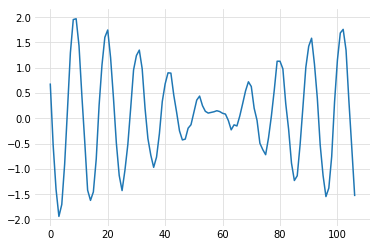

In [15]:
WAVEFORM_SELECT = 2 # select 0, 1 or 2

def create_time_series(datalen):
    # good waveforms
    frequencies = [(0.2, 0.15), (0.35, 0.3), (0.6, 0.55)]
    freq1, freq2 = frequencies[WAVEFORM_SELECT]
    noise = [np.random.random()*0.1 for i in range(datalen)]
    x1 = np.sin(np.arange(0,datalen) * freq1)  + noise
    x2 = np.sin(np.arange(0,datalen) * freq2)  + noise
    x = x1 + x2
    return x.astype(np.float32)

DATA_SEQ_LEN = 1024*128
data = create_time_series(DATA_SEQ_LEN)
plt.plot(data[5:112])
plt.show()

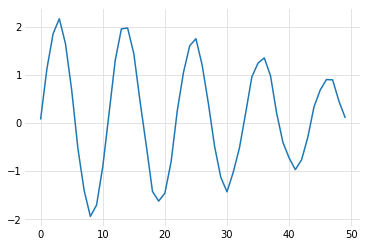

In [16]:
plt.plot(data[:50])
plt.show()

In [17]:
data.shape

(131072,)

<a name="hyperparameters"></a>
## Hyperparameters

In [18]:
NB_EPOCHS = 10

RNN_CELLSIZE = 128   # size of the RNN cells, default: 80
N_LAYERS = 1        # number of stacked RNN cells
SEQLEN = 32         # unrolled sequence length
BATCHSIZE = 32      # mini-batch size

DROPOUT_PKEEP = 0.75

## Visualize training sequences
This is what the neural network will see during training.

Features shape: (32, 32)
Labels shape: (32, 32)
Excerpt from first batch:


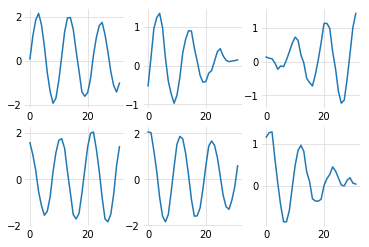

In [19]:
# The function dumb_minibatch_sequencer splits the data into batches of sequences sequentially.
for features, labels, epoch in utils_batching.dumb_minibatch_sequencer(data, BATCHSIZE, SEQLEN, nb_epochs=1):
    break
print("Features shape: " + str(features.shape))
print("Labels shape: " + str(labels.shape))
print("Excerpt from first batch:")

utils_display.picture_this_7(features)

In [22]:
labels.shape

(32, 32)

In [23]:
features.shape

(32, 32)

In [24]:
labels

array([[ 1.118514  ,  1.8501806 ,  2.1615083 , ..., -1.4282942 ,
        -1.0239745 , -0.51940435],
       [ 0.20210133,  0.95690304,  1.2421074 , ...,  0.1298655 ,
         0.15017667,  0.13399693],
       [ 0.09990177,  0.08403412, -0.04135969, ...,  1.0097443 ,
         1.4253806 ,  1.5839883 ],
       ...,
       [ 0.05792176, -0.25115904, -0.41553283, ..., -0.5144087 ,
        -0.77839684, -0.6392439 ],
       [-0.2877394 ,  0.39471725,  0.78096604, ..., -0.91177833,
        -1.5973276 , -1.7151251 ],
       [-1.1936445 , -0.3396133 ,  0.68431777, ..., -0.3131087 ,
        -1.070973  , -1.6802859 ]], dtype=float32)

<a name="assignment2"></a>
<a name="model"></a>
## The model definition
When executed, this function instantiates the Tensorflow graph for our model.

<div class="alert alert-block alert-info">
**Assignment #2**: implement a single-layer RNN using a GRU cell: `tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE)`
</div>

<a name="assignment3A"></a>
<div class="alert alert-block alert-info">
**Assignment #3.A**: check that state is passed around correctly: `dynamic_rnn(initial_state=Hin)`
</div>

<a name="assignment4"></a>
<div class="alert alert-block alert-info">
**Assignment #4**: Make the predictions more robust. You can try the following:
<ol><ol>
    <li> Use a stacked RNN cell with 2 layers with in the model:<br/>
```
cells = [tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE) for _ in range(N_LAYERS)]
cell = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=False)
```
        <br/>Do not forget to set N_LAYERS=2 in [hyperparameters](#hyperparameters) so that the input state gets initialized correctly.
    </li>
    <li> Regularisation: learning rate decay. Locate the line where the AdamOptimizer is instantiated and notice that this model uses an exponentially decaying learning rate. This allows you to train for longer. Set NB_EPOCHS=10 in [hyperparameters](#hyperparameters).</li>
</ol></ol>
Play with these options until you get a good fit for at least 128 predicted samples. You can then try a [different waveform](#assignment1). Dropout (another regularisation technique) could further improve this model but it is more interesting to try it out on real data: go to the next exercise for that.
</div>

![deep RNN schematic](images/RNN1.svg)
<div style="text-align: right; font-family: monospace">
  X shape [BATCHSIZE, SEQLEN, 1]<br/>
  Y shape [BATCHSIZE, SEQLEN, 1]<br/>
  H shape [BATCHSIZE, RNN_CELLSIZE*NLAYERS]
</div>

In [7]:
def model_fn(features, Hin, labels, step):
    # inputs shapes during training (for inference, we will use BATCHSIZE=1 and SEQLEN=1):
    # features [BATCHSIZE, SEQLEN, 1]
    # labels [BATCHSIZE, SEQLEN, 1]
    # Hin [BATCHSIZE, RNN_CELLSIZE*N_LAYERS]
    X = features
    batchsize = tf.shape(X)[0] # allow for variable batch size
    seqlen = tf.shape(X)[1] # allow for variable sequence length
    
    # --- dummy model: please implement a real RNN model ---
    Yn = X * tf.ones([RNN_CELLSIZE], name="dummy") # Yn shape [BATCHSIZE, SEQLEN, RNN_CELLSIZE]
    #H = Hin
    
    # single RNN
    cell = tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE)
    Yn, H = tf.nn.dynamic_rnn(cell=cell, inputs=Yn, initial_state=Hin, dtype=tf.float32)
    
    # TODO: create a tf.nn.rnn_cell.GRUCell
    # TODO: unroll the cell using tf.nn.dynamic_rnn
    # --- end of dummy model ---
    
    # This is the regression layer. It is already implemented.
    # Yn [BATCHSIZE, SEQLEN, RNN_CELLSIZE]
    Yn = tf.reshape(Yn, [batchsize*seqlen, RNN_CELLSIZE])
    Yr = tf.layers.dense(Yn, 1) # Yr [BATCHSIZE*SEQLEN, 1] predicting vectors of 1 element
    Yr = tf.reshape(Yr, [batchsize, seqlen, 1]) # Yr [BATCHSIZE, SEQLEN, 1]
    
    # Yr[BATCHSIZE, SEQLEN, 1]
    Yout = Yr[:,-1,:] # Last output in sequence Yout [BATCHSIZE, 1]
    
    loss = tf.losses.mean_squared_error(Yr, labels) # shapes Yr[BATCHSIZE, SEQLEN, 1], labels[BATCHSIZE, SEQLEN, 1]
    lr = 0.001 + tf.train.exponential_decay(0.01, step, 400, 0.5) # 0.001+0.01*0.5^(step/400)
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    train_op = optimizer.minimize(loss)
    
    return Yout, H, loss, train_op # output shapes Yout[BATCHSIZE, 1], H[BATCHSIZE, RNN_CELLSIZE*N_LAYERS]

## Instantiate the model

In [8]:
tf.reset_default_graph() # restart model graph from scratch

# placeholder for inputs
Hin = tf.placeholder(tf.float32, [None, RNN_CELLSIZE * N_LAYERS])
features = tf.placeholder(tf.float32, [None, None, 1]) # [BATCHSIZE, SEQLEN, 1]
labels = tf.placeholder(tf.float32, [None, None, 1]) # [BATCHSIZE, SEQLEN, 1]
step = tf.placeholder(tf.int32)

# instantiate the model
Yout, H, loss, train_op = model_fn(features, Hin, labels, step)

<a name="assignment3B"></a>
<a name="inference"></a>
## Inference
This is a generative model: run one trained RNN cell in a loop


<div class="alert alert-block alert-info">
**Assignment #3.B**: Check that the RNN state is passed around correctly (hint: it's OK)
</div>

In [9]:
def prediction_run(prime_data, run_length):
    H_ = np.zeros([1, RNN_CELLSIZE * N_LAYERS]) # zero state initially
    Yout_ = np.zeros([1, 1])
    data_len = prime_data.shape[0]

    # prime the state from data
    if data_len > 0:
        Yin = np.array(prime_data)
        Yin = np.reshape(Yin, [1, data_len, 1]) # reshape as one sequence of length data_len
        feed = {Hin: H_, features: Yin}
        Yout_, H_ = sess.run([Yout, H], feed_dict=feed)
    
    # run prediction
    # To generate a sequence, run a trained cell in a loop passing as input and input state
    # respectively the output and output state from the previous iteration.
    results = []
    for i in range(run_length):
        Yout_ = np.reshape(Yout_, [1, 1, 1]) # batch of a single sequence of a single vector with one element
        feed = {Hin: H_, features: Yout_}
        Yout_, H_ = sess.run([Yout, H], feed_dict=feed)
        results.append(Yout_[0,0])
        
    return np.array(results)

## Initialize Tensorflow session
This resets all neuron weights and biases to initial random values

In [10]:
# first input state
Hzero = np.zeros([BATCHSIZE, RNN_CELLSIZE * N_LAYERS])
# variable initialization
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run([init])

[None]

<a name="assignment3C"></a>
<a name="training"></a>
## The training loop
You can re-execute this cell to continue training

<div class="alert alert-block alert-info">
**Assignment #3.C**: find and resolve RNN state bugs.<br?>
**hint**: there are 2 bugs. One in the core of the training loop. Find the state and pass it around correctly. The second bug is in the way the data was sliced into batches of sequences. Special care is needed when batching sequences for an RNN. [See this slide](https://docs.google.com/presentation/d/18MiZndRCOxB7g-TcCl2EZOElS5udVaCuxnGznLnmOlE/pub?slide=id.g139650d17f_0_584) to understand the situation. You can fix it by using `rnn_minibatch_sequencer` instead of `dumb_minibatch_sequencer`)
</div>

In [11]:
H_ = Hzero
losses = []
indices = []
for i, (next_features, next_labels, epoch) in enumerate(utils_batching.rnn_minibatch_sequencer(data, BATCHSIZE, SEQLEN, nb_epochs=NB_EPOCHS)):
    next_features = np.expand_dims(next_features, axis=2) # model wants 3D inputs [BATCHSIZE, SEQLEN, 1] 
    next_labels = np.expand_dims(next_labels, axis=2)

#    feed = {Hin: Hzero, features: next_features, labels: next_labels, dropout_pkeep: DROPOUT_PKEEP}
    feed = {Hin: H_, features: next_features, step: i, labels: next_labels}
    Yout_, H_, loss_, _ = sess.run([Yout, H, loss, train_op], feed_dict=feed)
    # print progress
    if i%100 == 0:
        print("epoch " + str(epoch) + ", batch " + str(i) + ", loss=" + str(np.mean(loss_)))
    if i%10 == 0:
        losses.append(np.mean(loss_))
        indices.append(i)

epoch 0, batch 0, loss=0.9359583
epoch 0, batch 100, loss=0.0130127715
epoch 1, batch 200, loss=0.008291302
epoch 2, batch 300, loss=0.009078156
epoch 3, batch 400, loss=0.008572171
epoch 3, batch 500, loss=0.009373467
epoch 4, batch 600, loss=0.0066084
epoch 5, batch 700, loss=0.0068852035
epoch 6, batch 800, loss=0.0061171628
epoch 7, batch 900, loss=0.0057832794
epoch 7, batch 1000, loss=0.005616435
epoch 8, batch 1100, loss=0.005874861
epoch 9, batch 1200, loss=0.0055800756


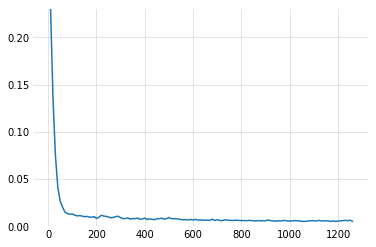

In [12]:
plt.ylim(ymax=np.amax(losses[1:])) # ignore first value for scaling
plt.plot(indices, losses)
plt.show()

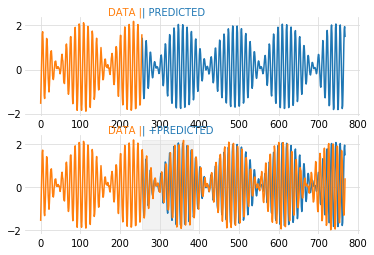

RMSE on 128 predictions (shaded area): 0.9089364321548368


In [13]:
PRIMELEN=256
RUNLEN=512
OFFSET=20
RMSELEN=128

prime_data = data[OFFSET:OFFSET+PRIMELEN]
results = prediction_run(prime_data, RUNLEN)

utils_display.picture_this_8(data, prime_data, results, OFFSET, PRIMELEN, RUNLEN, RMSELEN)

Copyright 2018 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
[http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.